Collect stock and option data, price with BSM, compare accuracy

In [1]:
import pandas as pd

from math import sqrt
import numpy as np
from scipy.stats import norm

import seaborn as sns

from datetime import datetime, timezone, timedelta


In [2]:
# initial parameters

ticker = 'GOOG'
risk_free_rate = 0.08
option_type = 'put'

# 2 weeks, 1m, 3m, 6m
# expiration_datetime = datetime(2020, 12, 4, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2020, 12, 11, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2020, 12, 24, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2021, 2, 19, 0, 0, tzinfo=timezone.utc)
expiration_datetime = datetime(2021, 6, 18, 0, 0, tzinfo=timezone.utc)


In [3]:
# get a UTC timestamp from a date. This is used to scrape data from Yahoo Finance.

expiration_timestamp = int(expiration_datetime.timestamp())

print(expiration_timestamp)
print(datetime.fromtimestamp(expiration_timestamp)) # this is in UTC, add 5 hours to this to get EST

# feb 19 2021

1623974400
2021-06-18 00:00:00


In [4]:
# !pip install lxml

Download historical stock price data for Google (GOOG). I get a past year's worth from (https://finance.yahoo.com/quote/GOOG/history?p=GOOG)

In [5]:
# download annual historical data for the stock

# stock_price_path = "~/documents/quant_finance/price_data/{}.csv".format(ticker)
stock_price_path = "price_data/{}.csv".format(ticker)
options_data_path = 'https://finance.yahoo.com/quote/{}/options?date={}&p={}'.format(ticker, expiration_timestamp, ticker)

df = pd.read_csv(stock_price_path)
df = df.sort_values(by="Date")
df = df.dropna()

# calculate returns
df = df.assign(close_day_before=df['Adj Close'].shift(1))
df['returns'] = ((df['Adj Close'] - df.close_day_before)/df.close_day_before)

# get options data
options_data = pd.read_html(options_data_path) # returns two dataframes, for calls and puts

if option_type == 'call':
    r = options_data[0]
elif option_type == 'put':
    r = options_data[1]

print(df)
print(r)

           Date         Open         High          Low        Close  \
0    2019-12-02  1301.000000  1305.829956  1281.000000  1289.920044   
1    2019-12-03  1279.569946  1298.461060  1279.000000  1295.280029   
2    2019-12-04  1307.010010  1325.800049  1304.869995  1320.540039   
3    2019-12-05  1328.000000  1329.358032  1316.439941  1328.130005   
4    2019-12-06  1333.439941  1344.000000  1333.439941  1340.619995   
..          ...          ...          ...          ...          ...   
249  2020-11-25  1772.890015  1778.540039  1756.540039  1771.430054   
250  2020-11-27  1773.089966  1804.000000  1772.439941  1793.189941   
251  2020-11-30  1781.183960  1788.064941  1755.000000  1760.739990   
252  2020-12-01  1774.369995  1824.829956  1769.369995  1798.099976   
253  2020-12-02  1798.099976  1835.650024  1789.472534  1827.949951   

       Adj Close   Volume  close_day_before   returns  
0    1289.920044  1510900               NaN       NaN  
1    1295.280029  1143800       128

In [6]:
# get risk free rate data

rfr_data_path = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
rfr_df = pd.read_html(rfr_data_path)[1] # returns two dataframes, for calls and puts
rfr_df

,Date,1 mo,2 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr,30 yr
0,12/01/20,0.07,0.07,0.09,0.1,0.12,0.17,0.22,0.42,0.68,0.92,1.46,1.66
1,12/02/20,0.07,0.08,0.09,0.1,0.11,0.16,0.22,0.42,0.69,0.95,1.50,1.70


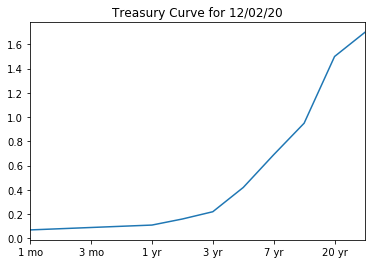

In [7]:
# plot the rfr
rfr_date = rfr_df.iloc[-1][0]

cur_rfr = rfr_df.iloc[-1][1:].astype(float)
cur_rfr.plot(title="Treasury Curve for {}".format(rfr_date))

In [8]:
# BSM model

# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma, option_type='call'):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type=='call':
        return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)
    elif option_type=='put':
        return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
        
# get the (num days to expiration) / (trading days in a year)
def get_time_to_expiration(expiration_datetime_utc):
    return (expiration_datetime_utc - datetime.now(timezone.utc)).days / 252


In [9]:
value_s = black_scholes(S = 69, 
                        K = 70, 
                        T = 6/12, 
                        r = .05, 
                        sigma = .35,
                        option_type='put')
print(value_s)

6.401407649076464


In [10]:
# the rfr should vary with time, not be constant.

cur_stock_price = df.iloc[-1]['Adj Close']
time_to_expiration = get_time_to_expiration(expiration_datetime)

# Calculate the volatility as the annualized standard deviation of the stock returns
sigma = np.sqrt(252) * df['returns'].std()

print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
list_estimates = []

strike_start_idx, strike_end_idx = 0, r.shape[0]
# strike_start_idx, strike_end_idx = 0, 21

# run BSM for different strikes
for x in range(strike_start_idx,strike_end_idx):
    value_s = black_scholes(S = cur_stock_price, 
                            K = r['Strike'][x], 
                            T = time_to_expiration, 
                            r = risk_free_rate, 
                            sigma = sigma,
                            option_type = option_type)
    list_estimates.append(value_s)
    
# merge the real and computed dataframes to compare results
df_list = pd.DataFrame(data=list_estimates, index=r.index[strike_start_idx:strike_end_idx])
df_list['estimate'] = df_list[0]
del df_list[0]
df_estimate = r.merge(df_list, right_index = True, left_index = True)

cur_stock_price: 1827.949951, time to expiration: 0.7777777777777778, rfr: 0.08, vol: 0.38212781123440914


In [11]:
df_estimate

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate
0,GOOG210618P00520000,2020-12-02 11:32AM EST,520.0,0.15,0.05,0.20,-0.15,-50.00%,111,899,55.96%,0.003265
1,GOOG210618P00540000,2020-12-01 12:29PM EST,540.0,0.20,0.00,0.35,0.00,-,1,164,55.86%,0.005388
2,GOOG210618P00560000,2020-10-29 11:18AM EST,560.0,1.25,0.00,0.85,0.00,-,1,217,59.01%,0.008636
3,GOOG210618P00580000,2020-07-01 8:54AM EST,580.0,5.50,3.00,4.50,0.00,-,1,31,74.88%,0.013480
4,GOOG210618P00600000,2020-11-25 1:39PM EST,600.0,0.24,0.05,0.65,0.00,-,1,228,54.64%,0.020534
5,GOOG210618P00620000,2020-08-19 1:00PM EST,620.0,3.00,0.00,5.00,0.00,-,1,32,66.75%,0.030584
6,GOOG210618P00640000,2020-08-18 2:48PM EST,640.0,3.24,1.50,2.65,0.00,-,1,22,63.27%,0.044617
7,GOOG210618P00660000,2020-08-10 12:02PM EST,660.0,5.65,3.80,5.20,0.00,-,15,28,68.85%,0.063853
8,GOOG210618P00680000,2020-11-06 11:21AM EST,680.0,1.30,0.05,0.85,0.00,-,1,153,50.00%,0.089771
9,GOOG210618P00700000,2020-12-02 3:15PM EST,700.0,0.53,0.15,0.95,-0.17,-24.29%,1,71,52.76%,0.124141


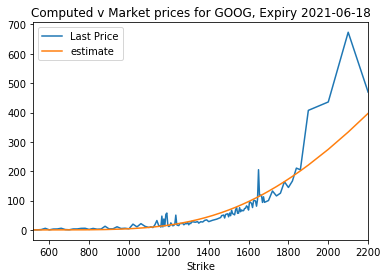

In [12]:
# plot option prices across strikes

df_estimate.plot(x='Strike',y=['Last Price','estimate'], title='Computed v Market prices for {}, Expiry {}'.format(ticker, expiration_datetime.date()))

count      139.000000
mean       730.263463
std       3862.921848
min        -38.260741
25%        -21.539273
50%         -7.774220
75%         71.604271
max      40700.062332
Name: estimate_error, dtype: float64


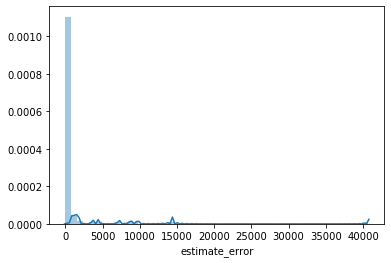

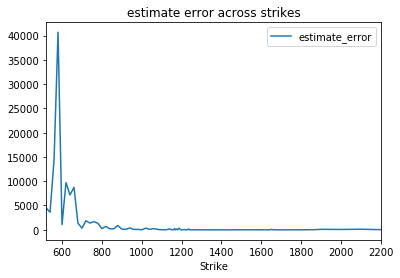

In [13]:
df_estimate['estimate_error'] = ((df_estimate['Last Price'] - df_estimate['estimate'])/df_estimate['estimate'])*100
ax = sns.distplot(df_estimate['estimate_error'])
print(df_estimate['estimate_error'].describe())

# across strikes, the median error is 34%, but there is a huge spread and outliers, 
# which mainly seem to be due to the higher strikes being very close to 0.

# plot the error across strikes

df_estimate.plot(x='Strike',y='estimate_error',title='estimate error across strikes')

In [14]:
# what is a measure of error?
# MSE: average of the sum of squared errors

mse = np.sum((df_estimate['Last Price'] - df_estimate['estimate'])**2) / df_estimate.shape[0]
rmse = np.sqrt(mse)

print(mse, rmse)
# could also try MAD

1555.921413793013 39.44516971433908


In [15]:
# examine outliers

df_estimate[df_estimate['estimate_error'].abs() > 1]

# the model tends to undervalue puts especially at high strikes (deep out of the money).

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate,estimate_error
0,GOOG210618P00520000,2020-12-02 11:32AM EST,520.0,0.15,0.05,0.20,-0.15,-50.00%,111,899,55.96%,0.003265,4494.040577
1,GOOG210618P00540000,2020-12-01 12:29PM EST,540.0,0.20,0.00,0.35,0.00,-,1,164,55.86%,0.005388,3612.055727
2,GOOG210618P00560000,2020-10-29 11:18AM EST,560.0,1.25,0.00,0.85,0.00,-,1,217,59.01%,0.008636,14373.731205
3,GOOG210618P00580000,2020-07-01 8:54AM EST,580.0,5.50,3.00,4.50,0.00,-,1,31,74.88%,0.013480,40700.062332
4,GOOG210618P00600000,2020-11-25 1:39PM EST,600.0,0.24,0.05,0.65,0.00,-,1,228,54.64%,0.020534,1068.786308
5,GOOG210618P00620000,2020-08-19 1:00PM EST,620.0,3.00,0.00,5.00,0.00,-,1,32,66.75%,0.030584,9709.082805
6,GOOG210618P00640000,2020-08-18 2:48PM EST,640.0,3.24,1.50,2.65,0.00,-,1,22,63.27%,0.044617,7161.751414
7,GOOG210618P00660000,2020-08-10 12:02PM EST,660.0,5.65,3.80,5.20,0.00,-,15,28,68.85%,0.063853,8748.417437
8,GOOG210618P00680000,2020-11-06 11:21AM EST,680.0,1.30,0.05,0.85,0.00,-,1,153,50.00%,0.089771,1348.124059
9,GOOG210618P00700000,2020-12-02 3:15PM EST,700.0,0.53,0.15,0.95,-0.17,-24.29%,1,71,52.76%,0.124141,326.933101


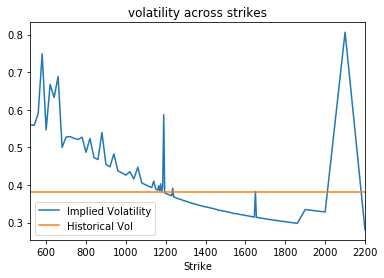

In [16]:
# how accurate are our vol estimates?

df_estimate['Implied Volatility'] = df_estimate['Implied Volatility'].str.replace(',','').str.slice(stop=-1).astype('float') / 100

df_estimate['Historical Vol'] = sigma
ax = df_estimate.plot(x='Strike',y=['Implied Volatility','Historical Vol'],title='volatility across strikes')

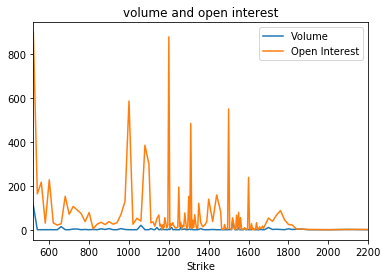

In [17]:
df_estimate['Volume'] = df_estimate['Volume'].replace(to_replace='-',value=0)
df_estimate['Volume'] = df_estimate['Volume'].astype('int')

df_estimate['Open Interest'] = df_estimate['Open Interest'].replace(to_replace='-',value=0)
df_estimate['Open Interest'] = df_estimate['Open Interest'].astype('int')

df_estimate.plot(x='Strike',y=['Volume','Open Interest'],title='volume and open interest')

count    139.000000
mean      64.633094
std      137.448760
min        1.000000
25%        6.000000
50%       23.000000
75%       54.500000
max      899.000000
Name: Open Interest, dtype: float64


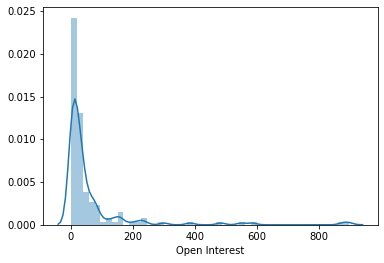

In [18]:
sns.distplot(df_estimate['Open Interest'])
print(df_estimate['Open Interest'].describe())

count       83.000000
mean      1208.392351
std       4952.807073
min        -38.260741
25%        -23.859948
50%         -4.954627
75%        191.533467
max      40700.062332
Name: estimate_error, dtype: float64


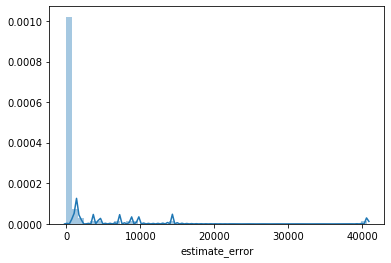

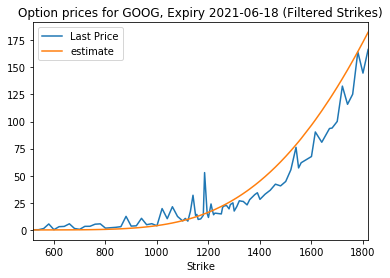

In [19]:
# filter out low volume options

# lower_bound, upper_bound = cur_stock_price * .5, cur_stock_price * 1.5
# price_estimate_filtered = df_estimate[(df_estimate['Strike'] > lower_bound) & (df_estimate['Strike'] < upper_bound)].reset_index()

price_estimate_filtered = df_estimate[(df_estimate['Open Interest'] > 15)].reset_index()
ax = sns.distplot(price_estimate_filtered['estimate_error'])
print(price_estimate_filtered['estimate_error'].describe())

price_estimate_filtered.plot(x='Strike',y=['Last Price','estimate'], title='Option prices for {}, Expiry {} (Filtered Strikes)'.format(ticker, expiration_datetime.date()))


cur_stock_price: 1827.949951, time to expiration: 0.7777777777777778, rfr: 0.08, vol: 0.38212781123440914


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


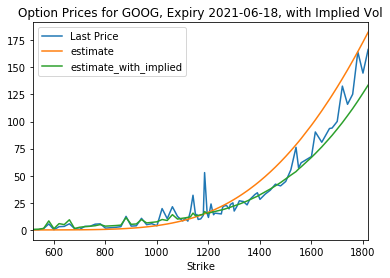

In [20]:
# if we use implied vol instead of historical vol, our estimate should improve

def calculate_prices_across_strikes(options_df, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type):

    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
    list_estimates = []
    estimates_with_implied = []

    strike_start_idx, strike_end_idx = 0, options_df.shape[0]

    # run BSM for different strikes
    for x in range(strike_start_idx,strike_end_idx):
#         print(options_df['Strike'][x])
        value_s = black_scholes(S = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = sigma,
                                option_type = option_type)
        list_estimates.append(value_s)
        
    for x in range(strike_start_idx,strike_end_idx):
#         print(options_df['Strike'][x])
        value_s = black_scholes(S = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = options_df['Implied Volatility'][x],
                                option_type = option_type)
        estimates_with_implied.append(value_s)

    # merge the real and computed dataframes to compare results
    df_estimate = options_df[['Strike','Last Price']]
    df_estimate['estimate'] = list_estimates
    df_estimate['estimate_with_implied'] = estimates_with_implied

    return df_estimate

df_estimate_european = calculate_prices_across_strikes(price_estimate_filtered, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type)
df_estimate_european.plot(x='Strike',y=['Last Price','estimate','estimate_with_implied'], title='Option Prices for {}, Expiry {}, with Implied Vol'.format(ticker, expiration_datetime.date()))

In [21]:

df_estimate_european['estimate_with_implied_error'] = ((df_estimate_european['Last Price'] - df_estimate_european['estimate_with_implied'])/df_estimate_european['estimate_with_implied'])*100
ax = sns.distplot(df_estimate_european['estimate_with_implied_error'])
print(df_estimate_european['estimate_with_implied_error'].describe())
df_estimate_european.plot(x='Strike',y='estimate_with_implied_error',title='Estimate Percent Error Across Strikes (Filtered Strikes)')

mse = np.sum((df_estimate_european['Last Price'] - df_estimate_european['estimate_with_implied'])**2) / df_estimate_european.shape[0]
rmse = np.sqrt(mse)

print(mse, rmse)

KeyError: 'estimate_with_implied'

In [22]:
# American options

from functions.BS_pricer import BS_pricer
from functions.Parameters import Option_param
from functions.Processes import Diffusion_process
from functions.cython.cython_functions import PSOR

import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))
    

In [23]:
# Longstaff Schwartz Method

def price_american(S0, K, T, r, sigma, payoff='call'):
    
    # Creates the object with the parameters of the option
    opt_param = Option_param(S0=S0, K=K, T=T, exercise="American", payoff=payoff )
    # Creates the object with the parameters of the process
    diff_param = Diffusion_process(r=r, sig=sigma)
    # Creates the pricer object
    BS = BS_pricer(opt_param, diff_param)
    
#     return BS.LSM(N=1000, paths=1000, order=2)  # Longstaff Schwartz Method
    N_space = 8000
    N_time = 5000
    return BS.PDE_price((N_space,N_time))

# def plot_american(BS, x_start, x_end, y_start, y_end):
    
#     fig = plt.figure(figsize=(9,5))
#     BS.plot([x_start,x_end,y_start,y_end])

In [24]:
# price_american(S0=100, K=100, T=1, r=0.1, sigma=0.2, payoff="put" )
# 1827.949951 1110.0 0.7817460317460317 0.08 0.38212781123440914 put
price_american(S0=1827.949951, K=1110.0, T=0.7817460317460317, r=0.08, sigma=0.38212781123440914, payoff="put" )


cur_stock_price: 1827.949951, time to expiration: 0.7777777777777778, rfr: 0.08, vol: 0.2
strike 520.0
strike 720.0
strike 940.0
strike 1120.0
strike 1200.0
strike 1285.0
strike 1390.0
strike 1560.0
strike 1780.0
0     8.655832e-13
10    2.991858e-07
20    9.517629e-04
30    6.108268e-02
40    2.475580e-01
50    8.717275e-01
60    3.169869e+00
70    1.591410e+01
80    6.918282e+01
dtype: float64
CPU times: user 17.1 s, sys: 348 ms, total: 17.5 s
Wall time: 17.4 s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


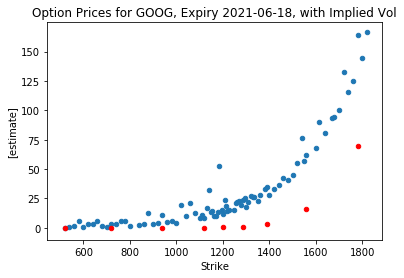

In [35]:
%%time

# if we use implied vol instead of historical vol, our estimate should improve

def calculate_prices_across_strikes_american(options_df, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type):

    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
    index = []
    list_estimates = []
#     estimates_with_implied = []

    strike_start_idx, strike_end_idx = 0, options_df.shape[0]
    step = 10

    # run BSM for different strikes
    for x in range(strike_start_idx,strike_end_idx, step):
        index.append(x)
        print('strike', options_df['Strike'][x])
        value_s = price_american(S0 = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = sigma,
                                payoff = option_type)
        list_estimates.append(value_s)
        
#         print(cur_stock_price, options_df['Strike'][x], time_to_expiration, risk_free_rate, options_df['Implied Volatility'][x], option_type)
#         value_s = price_american(S0 = cur_stock_price, 
#                                 K = options_df['Strike'][x], 
#                                 T = time_to_expiration, 
#                                 r = risk_free_rate, 
#                                 sigma = options_df['Implied Volatility'][x],
#                                 payoff = option_type)
#         estimates_with_implied.append(value_s)

    # merge the real and computed dataframes to compare results
    price_estimates = pd.Series(data=list_estimates, index=index)
    print(price_estimates)
#     df_estimate['estimate_with_implied'] = estimates_with_implied
    df_estimate = options_df[['Strike','Last Price']]
    df_estimate['estimate'] = price_estimates

    return df_estimate

df_estimate_american = calculate_prices_across_strikes_american(price_estimate_filtered, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type)
# df_estimate.plot(x='Strike',y=['Last Price','estimate','estimate_with_implied'], title='Option Prices for {}, Expiry {}, with Implied Vol'.format(ticker, expiration_datetime.date()))
# df_estimate.plot(x='Strike',y=['Last Price','estimate'], title='Option Prices for {}, Expiry {}, with Implied Vol'.format(ticker, expiration_datetime.date()))

ax1 = df_estimate_american.plot(kind='scatter', x='Strike',y=['Last Price'], title='Option Prices for {}, Expiry {}, with Implied Vol'.format(ticker, expiration_datetime.date()))
df_estimate_american.plot(kind='scatter', x='Strike',y=['estimate'], ax=ax1, color='r')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


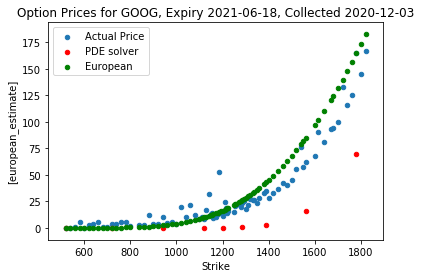

In [45]:
# compare with european

df_estimate_american['european_estimate'] = df_estimate_european['estimate']
df_estimate_american['european_estimate_with_implied'] = df_estimate_european['estimate_with_implied']

ax1 = df_estimate_american.plot(kind='scatter', x='Strike',y=['Last Price'], label='Actual Price')
df_estimate_american.plot(kind='scatter', x='Strike',y=['estimate'], ax=ax1, color='r', label='PDE solver')
df_estimate_american.plot(kind='scatter', x='Strike',y=['european_estimate'], ax=ax1, color='g', label='European')
# df_estimate.plot(kind='scatter', x='Strike',y=['estimate'], ax=ax1, color='r')
ax1.set_title('Option Prices for {}, Expiry {}, Collected {}'.format(ticker, expiration_datetime.date(), datetime.now().date()))
ax1.legend()

In [43]:
datetime.now().date()


datetime.date(2020, 12, 3)

In [28]:
# how accurate is BSM for different expiration dates?

# import os 

# data_path = "/home/amao/options_data/2020-11-19 17:00:01.568118"

# ticker = 'TSLA'
# calls_data, puts_data = dict(), dict()

# for filename in os.listdir(data_path):
#     if ticker in filename:
#         df = pd.read_csv(os.path.join(data_path, filename))
#         if 'puts' in filename :
#             puts_data[filename] = df
#         elif 'calls' in filename:
#             calls_data[filename] = df
        
# print(len(calls_data), len(puts_data))

In [29]:
# stock_price_df = df

# for k,v in calls_data.items():
#     print(k, v.head())
#     bsm_estimate_df = calculate_prices_across_strikes(v, cur_stock_price, time_to_expiration, risk_free_rate, sigma):


In [30]:
# binomial tree
import math

sigma = .2
rfr = .02
delta_t = 1

u = math.exp(sigma * math.sqrt(delta_t))
d = math.exp(-sigma * math.sqrt(delta_t))
print('u and d:',u,d)

# a = math.exp(rfr * delta_t)
a = math.exp((rfr - .01) * delta_t)
p = (a - d)/(u - d)

print('p', p)


u and d: 1.2214027581601699 0.8187307530779818
p 0.47512469600943963


In [31]:
# N period binomial tree model

def price_option_european(S_0, u, d, K, option_type: str, num_periods: int):
    
    if num_periods == 0:
        if option_type == 'call':
            return max(S_0-K, 0)
        elif option_type == 'put':
            return max(K-S_0, 0)
    else:
        S_u = S_0 * u
        S_d = S_0 * d
        
        f_u = price_option_european(S_0 * u,u,d,K,option_type,num_periods-1)
        f_d = price_option_european(S_0 * d,u,d,K,option_type,num_periods-1)
        
#         print('f_u and f_d:', f_u, f_d)

        return math.exp(-rfr*delta_t) * (p*f_u + (1-p)*f_d)

S_0 = 200
K = 200
option_type = 'put'

for i in range(5):
    price = price_option_european(S_0, u, d, K, option_type, num_periods=i)
    print('price',price)
    

price 0
price 18.65195571686643
price 17.452716560268637
price 25.695678025946652
price 24.44307753439426


In [32]:
def price_option_american(S_0, u, d, K, option_type: str, num_periods: int):
    
    if num_periods == 0:
        if option_type == 'call':
            return max(S_0-K, 0)
        elif option_type == 'put':
            return max(K-S_0, 0)
    else:
        S_u = S_0 * u
        S_d = S_0 * d
        
        f_u = price_option_american(S_0 * u,u,d,K,option_type,num_periods-1)
        f_d = price_option_american(S_0 * d,u,d,K,option_type,num_periods-1)
        
        if option_type == 'call':
            f_u_early = max(S_u-K, 0)
            f_d_early = max(S_d-K, 0)
        elif option_type == 'put':
            f_u_early = max(K-S_u, 0)
            f_d_early = max(K-S_d, 0)
#         print('f_u,f_d,f_u_early,f_d_early:',f_u,f_d,f_u_early,f_d_early)
        f_u = max(f_u,f_u_early)
        f_d = max(f_u,f_d_early)
        
#         print('f_u and f_d:', f_u, f_d)

        return math.exp(-rfr*delta_t) * (p*f_u + (1-p)*f_d)

S_0 = 200
K = 200
option_type = 'put'

for i in range(5):
    price = price_option_american(S_0, u, d, K, option_type, num_periods=i)
    print('price',price)

price 0
price 18.65195571686643
price 18.65195571686643
price 18.65195571686643
price 18.65195571686643
